In [15]:
!pip install cv2

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [1]:
# Models based on https://github.com/nicknochnack/GANBasics/blob/main/FashionGAN-Tutorial.ipynb

# Bringing in tensorflow datasets
import tensorflow_datasets as tfds

# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

import tensorflow as tf
import numpy as np
#import cv2

# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
ds = tfds.load('symmetric_solids', split='train')

In [4]:
#tfds.builder('symmetric_solids').info
#dataiterator.next()['image'][:,:,0].reshape((224,224,1)).shape
#dataiterator.next()['image'].reshape((224,224,1))

def resize_image(large_image):
    #large_image = large_image['image']
    # large image is shape (224, 224, 3)
    # small image is shape (56, 56, 3)
    input_size = 224
    output_size = 28
    bin_size = input_size // output_size
    small_image = large_image.reshape((output_size, bin_size, 
                                   output_size, bin_size, 3)).max(3).max(1)
    return small_image
    
def make_mono(image, size=28):
    return image[:,:,0].reshape((size, size, 1))
    
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

def resize_scale_mono(data, size = 28):    
    image = data['image']
    image = tf.image.resize(image, (size, size))
    image = image[:,:,0].reshape((size, size, 1))
    image = image / 255.0
    #print(image.shape)
    return image

#resize_image(dataiterator.next()['image']).shape

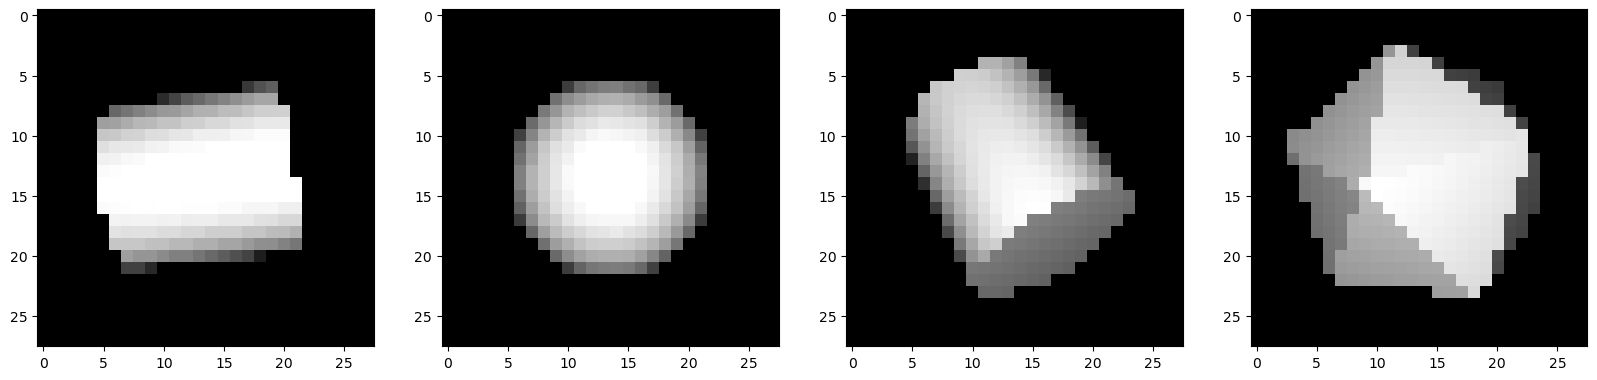

In [39]:
dataiterator = ds.as_numpy_iterator()
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    #ax[idx].imshow(np.squeeze(sample['image']))
    # Plot a 8x downsized, monocolored
    ax[idx].imshow(np.squeeze(make_mono(resize_image(sample['image']))), cmap='gray')
    # Appending the image label as the plot title 
    #ax[idx].title.set_text(sample['label'])

In [41]:
# Reload the dataset 
ds = tfds.load('symmetric_solids', split='train')
# Running the dataset through the scale_images preprocessing step
#ds = ds.map(scale_images)
ds = ds.map(resize_scale_mono)
#ds = ds.map(make_mono)
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [42]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [5]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [6]:
generator = build_generator()
discriminator = build_discriminator()

In [ ]:
# Generate new solids
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img1 in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img1))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)